In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


#  **EXPLORATORY ANALYSIS** 

**Understanding our dataset.**

Here we have a dataset with 8 columns:

***transaction_id:*** identification of the transaction

***merchant_id:*** identification of the merchant

***user_id:*** identification of the user

***card_number:*** number of the card used in the transaction

***transaction_date:*** when the transaction took place

***transaction_amount:*** the amount of the transaction

***device_id:*** the identification of the device used in the transaction (some of them are missing)

***has_cbk*:** tell us if chargeback happened or not.

In [2]:
df = pd.read_csv('https://gist.githubusercontent.com/cloudwalk-tests/76993838e65d7e0f988f40f1b1909c97/raw/9ceae962009236d3570f46e59ce9aa334e4e290f/transactional-sample.csv')
df.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False


In [3]:
df.columns

Index(['transaction_id', 'merchant_id', 'user_id', 'card_number',
       'transaction_date', 'transaction_amount', 'device_id', 'has_cbk'],
      dtype='object')

In [4]:
df['transaction_amount'].describe()

count    3199.000000
mean      767.812904
std       889.095904
min         1.220000
25%       205.235000
50%       415.940000
75%       981.680000
max      4097.210000
Name: transaction_amount, dtype: float64

In [5]:
df.isna().sum()

transaction_id          0
merchant_id             0
user_id                 0
card_number             0
transaction_date        0
transaction_amount      0
device_id             830
has_cbk                 0
dtype: int64

In [6]:
nunique_users = df["user_id"].nunique()
nunique_merchants = df["merchant_id"].nunique()

print("Dataset length is", len(df))
print("Number of unique users is " + str(nunique_users))
print("Number of unique merchants is " + str(nunique_merchants))

Dataset length is 3199
Number of unique users is 2704
Number of unique merchants is 1756


In [7]:
print(type(df['transaction_date'].iloc[0]))

<class 'str'>


In [8]:
convert_to_datetime = pd.to_datetime(df['transaction_date'])
df['transaction_date'] = convert_to_datetime

print(type(df['transaction_date'].iloc[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [9]:
timeframe = df["transaction_date"].agg([max,min])
timewindow = timeframe.max() - timeframe.min()
print(timeframe, timewindow)

max   2019-12-01 23:16:32.812632
min   2019-11-01 01:27:15.811098
Name: transaction_date, dtype: datetime64[ns] 30 days 21:49:17.001534


Ok. We can see that the dataset is comprised of one month of transactions, that happened between November 1, 2019 and December 1, 2019.

Now we know that it is about **3199 transactions that happened between the month of November and the first day of December 2019.**

# **UNDERSTANDING THE TRANSACTIONS**

Hypothesis 1: Suspicious behaviour is connected to transaction amount.

In [10]:
max_min_transactions = df["transaction_amount"].agg([max,min])
max_min_transactions

max    4097.21
min       1.22
Name: transaction_amount, dtype: float64

In [11]:
df.rename(columns={'has_cbk':'chargeback'}, inplace=True)
df.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,chargeback
0,21320398,29744,97051,434505******9116,2019-12-01 23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01 22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01 21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01 21:30:53.347051,55.36,860232.0,False


In [12]:
#Subsetting only chargebacks
df2 = df[df['chargeback'] == True]

#Ratio of number of transactions with chargebacks to total transactions
ratio_cbk = round(len(df2) / len(df) * 100)
print("The number of transactions where chargeback happened is " + str(len(df2)) + ", which is " + str(ratio_cbk) + "% of total transactions.")

The number of transactions where chargeback happened is 391, which is 12% of total transactions.


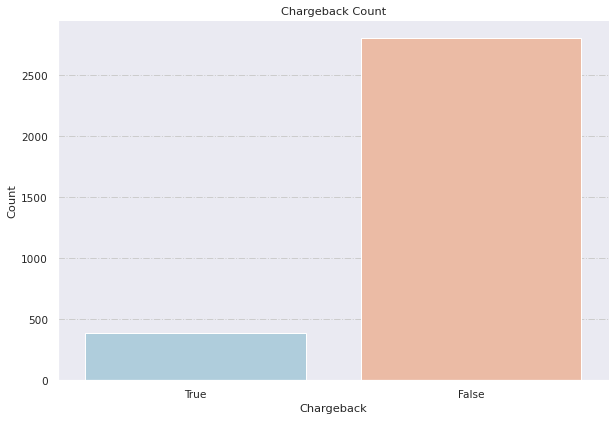

In [13]:
#Visualizing the difference

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": "-."})
sns.set_context("notebook", font_scale=0.95)

sns.catplot(
    data=df, x="chargeback", 
            order=[True,False], kind='count', height = 5.8,
                aspect=6.3/4.2, palette='RdBu_r'
)

plt.title("Chargeback Count")
plt.xlabel("Chargeback")
plt.ylabel("Count")
plt.show()

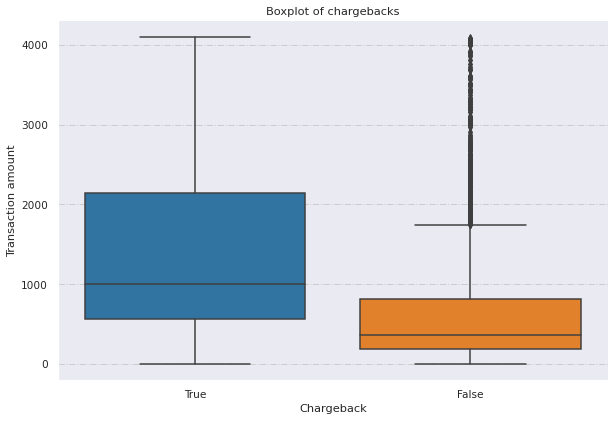

In [14]:
#How different the transaction amount is for each category?

sns.catplot(
    data=df,x='chargeback',y='transaction_amount',
                kind='box',order=[True,False],
                    height = 5.8, aspect=6.3/4.2
)

plt.title("Boxplot of chargebacks")
plt.xlabel("Chargeback")
plt.ylabel("Transaction amount")
plt.show()

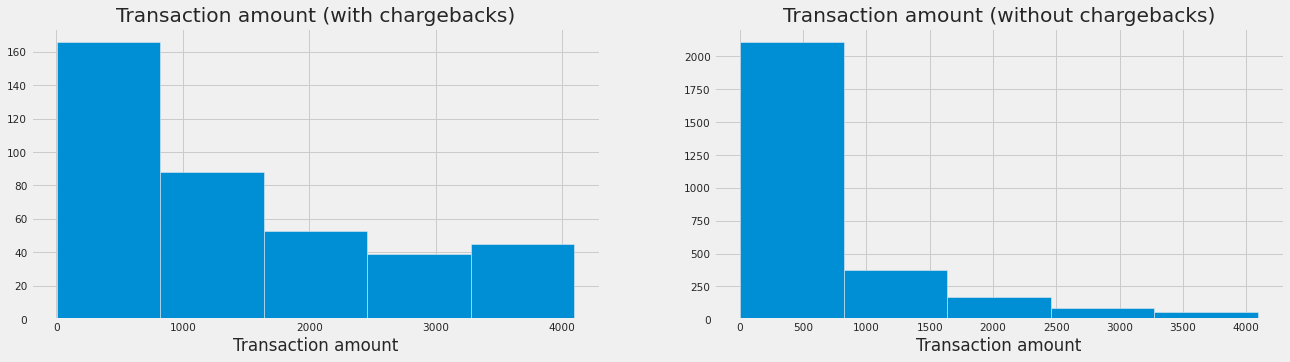

In [15]:
#Splitting the dataset into two: whether chargeback happened or not
true_set = df[df['chargeback'] == True]
false_set = df[df['chargeback'] == False]

#Plotting the transaction for each set
plt.style.use('fivethirtyeight')
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

ax0.hist(x=true_set['transaction_amount'], bins=5, histtype='bar')
ax0.set(
    title="Transaction amount (with chargebacks)", 
        xlabel="Transaction amount"
)

ax1.hist(x=false_set['transaction_amount'], bins=5, histtype='bar')
ax1.set(
    title = "Transaction amount (without chargebacks)", 
        xlabel="Transaction amount"
)

plt.show()

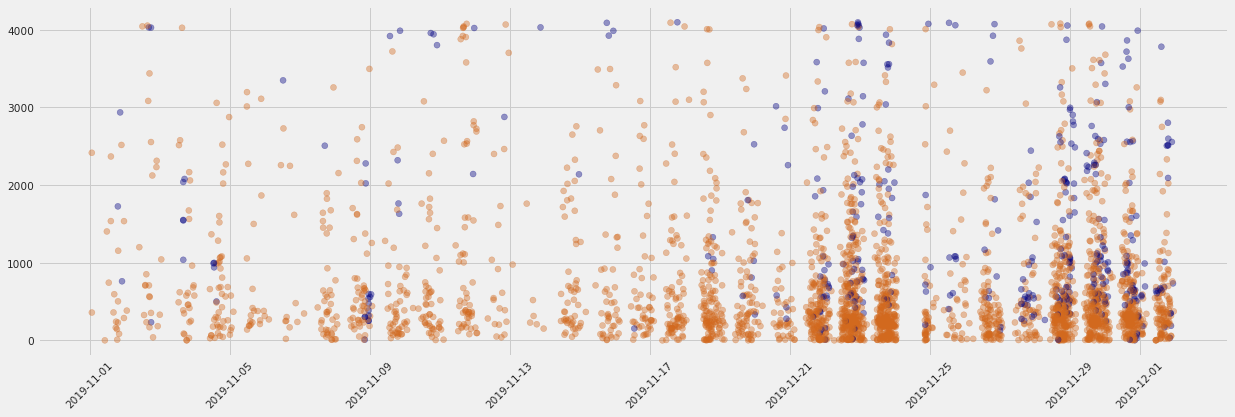

In [16]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(19,6))

colors = []

for key, value in df.iterrows():
    if value['chargeback'] == True:
        colors.append('navy')
    else:
        colors.append('chocolate')

plt.scatter(df['transaction_date'], df['transaction_amount'],c=colors, alpha=0.4)
plt.xticks(rotation=45)
plt.show()

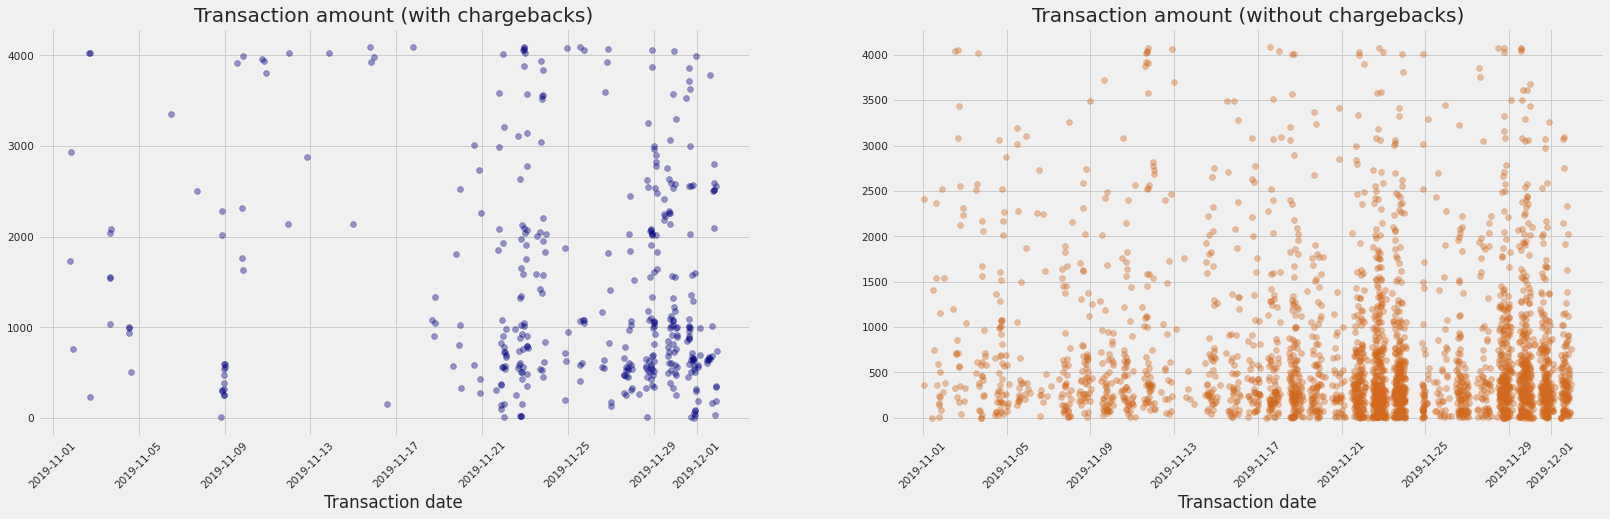

In [17]:
plt.style.use('fivethirtyeight')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,7))

ax0.scatter(x=true_set['transaction_date'], y=true_set['transaction_amount'], 
                            c='navy', alpha=0.4)
ax0.set(
    title="Transaction amount (with chargebacks)", 
        xlabel="Transaction date")
ax0.tick_params(axis='x',rotation=45)

ax1.scatter(x=false_set['transaction_date'], y=false_set['transaction_amount'], 
                            c='chocolate', alpha=0.4)
ax1.set(
    title="Transaction amount (without chargebacks)", 
        xlabel="Transaction date")
ax1.tick_params(axis='x',rotation=45)

plt.show()

>  Hypothesis 1 refused. There's no relevant difference between the transaction amount with and without chargeback request.

# **UNDERSTANDING USER BEHAVIOUR**

Hypothesis 2: Suspiciousness is connected to user behaviour.

In [18]:
true_set.head(15)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,chargeback
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:37.873639,734.87,497105.0,True
3,21320401,68657,69758,464296******3991,2019-12-01 21:59:19.797129,2556.13,NaN,True
7,21320405,56107,81152,650516******9201,2019-12-01 21:24:05.608374,188.68,486.0,True
8,21320406,56107,81152,650516******9201,2019-12-01 21:13:21.529999,352.77,486.0,True
9,21320407,56107,81152,650516******9201,2019-12-01 21:04:55.066909,345.68,486.0,True
13,21320411,56107,81152,650516******7004,2019-12-01 20:36:55.091278,32.86,486.0,True
26,21320424,53816,5541,606282******3381,2019-12-01 19:31:20.047571,2597.51,656429.0,True
28,21320426,11470,5541,606282******3381,2019-12-01 19:26:01.352512,2511.43,656429.0,True
30,21320428,73271,7725,489391******7420,2019-12-01 19:22:45.419831,2092.79,308950.0,True
32,21320430,56977,69758,464296******3991,2019-12-01 19:17:21.731168,2803.32,NaN,True


Just by looking at the dataset, we can see: 
* Customers who are connected to several transactions in the same store, with different values, and filed for chargebacks in all of them (for e.g.: merchant_id 56107 and user_id 81152)
* Customers who did transactions of similar values, with different merchants, and has chargeback in all of them (user_id 5541).

Let's take a closer look.

In [19]:
#Example of this behaviour: user_id 81152 and 5541

suspicious_users = true_set[(true_set['user_id'] == 81152) | (true_set['user_id'] == 5541)]
suspicious_users

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,chargeback
7,21320405,56107,81152,650516******9201,2019-12-01 21:24:05.608374,188.68,486.0,True
8,21320406,56107,81152,650516******9201,2019-12-01 21:13:21.529999,352.77,486.0,True
9,21320407,56107,81152,650516******9201,2019-12-01 21:04:55.066909,345.68,486.0,True
13,21320411,56107,81152,650516******7004,2019-12-01 20:36:55.091278,32.86,486.0,True
26,21320424,53816,5541,606282******3381,2019-12-01 19:31:20.047571,2597.51,656429.0,True
28,21320426,11470,5541,606282******3381,2019-12-01 19:26:01.352512,2511.43,656429.0,True
34,21320432,49710,5541,606282******3381,2019-12-01 19:12:42.641216,2515.13,656429.0,True


Let's identify if it is a usual behaviour for users with more than one transaction with chargeback. Taking in consideration that we are dealing only with cases where chargeback was filed, let's set up some rules to try to find a pattern:

**1.  There are users who did more than one transaction, with the same merchant, and have transactions with chargeback.**

**2. There are users who did more than one transaction, with more than one merchant, and have transactions with chargeback.**

**3. There are users associated with multiple card numbers, and have transactions with chargeback.**

In [20]:
#Count of transactions associated with each user
transact_p_user_count = true_set.groupby('user_id')['transaction_id'].count()

#Filter for those did more than one transaction
one_transaction = transact_p_user_count[transact_p_user_count == 1]
more_than_one_transaction = transact_p_user_count[transact_p_user_count > 1]

print("There are " + str(len(one_transaction)) + " users with one transaction with chargeback.")
print("There are " + str(len(more_than_one_transaction)) + " users with more than one transaction with chargeback.")

There are 75 users with one transaction with chargeback.
There are 78 users with more than one transaction with chargeback.


In [21]:
df_transact_p_user_count = pd.DataFrame(transact_p_user_count)
print(round(df_transact_p_user_count['transaction_id'].agg([max,min,np.mean,np.median])))

max       25.0
min        1.0
mean       3.0
median     2.0
Name: transaction_id, dtype: float64


Let's dive into the users with more than one transaction with chargeback.

In [22]:
print(round(more_than_one_transaction.agg([max,min,np.mean,np.median])))

max       25.0
min        2.0
mean       4.0
median     3.0
Name: transaction_id, dtype: float64


In [23]:
#Let's get our top five

mtot = pd.DataFrame(more_than_one_transaction)
mtot_top_5 = mtot.sort_values(
    by='transaction_id', ascending=False).head(5).reset_index().rename(
    columns={'transaction_id':'transaction_count'}
)

mtot_top_5

,user_id,transaction_count
0,11750,25
1,91637,19
2,79054,15
3,96025,13
4,78262,12


By doing some visualizations, we can understand their transaction behaviour.

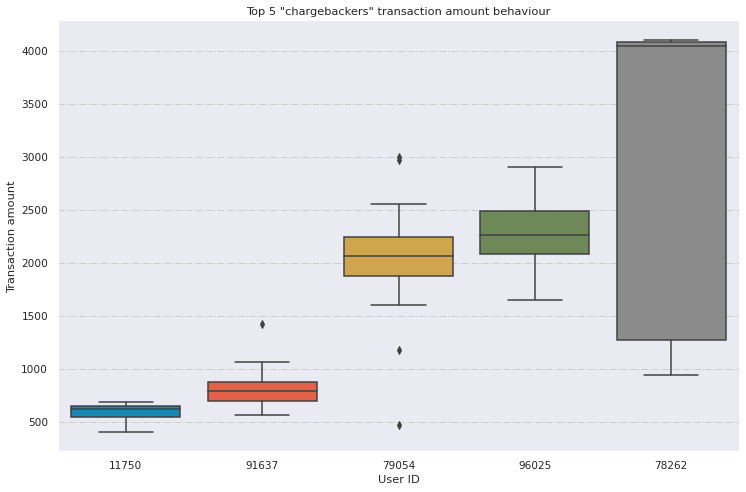

In [24]:
#To bring their transactions, we will need to merge our top 5 df with true_set

true_set_w_top_5 = mtot_top_5.merge(true_set, on='user_id', how='inner').sort_values(by='transaction_count', ascending=False)

#Boxplot!
sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": "-."})
sns.set_context("notebook", font_scale=0.95)

sns.catplot(
    data=true_set_w_top_5, x='user_id', 
    y='transaction_amount', height = 6.8, aspect=6.5/4.2, 
                kind='box',order=[11750,91637,79054,96025,78262]
)

plt.title('Top 5 "chargebackers" transaction amount behaviour')
plt.xlabel("User ID")
plt.ylabel("Transaction amount")

plt.show()

In [25]:
true_set_w_top_5.head(15).drop(columns='transaction_count')

,user_id,transaction_id,merchant_id,card_number,transaction_date,transaction_amount,device_id,chargeback
0,11750,21320460,66876,453211******1392,2019-12-01 16:43:09.730317,687.57,342890.0,True
13,11750,21320931,17275,453211******8822,2019-11-29 19:02:16.941360,528.46,342890.0,True
1,11750,21320498,17275,453211******1531,2019-12-01 14:02:31.156851,674.23,342890.0,True
24,11750,21322189,17275,498401******9945,2019-11-22 19:39:12.379371,506.11,542535.0,True
23,11750,21321874,17275,498401******6342,2019-11-23 18:35:42.143054,529.86,670695.0,True
22,11750,21321796,17275,498401******1451,2019-11-23 21:08:28.644798,619.63,542535.0,True
21,11750,21321676,17275,453211******8383,2019-11-25 12:51:42.413190,405.08,670695.0,True
20,11750,21321670,17275,406655******2518,2019-11-25 13:54:52.124291,580.79,542535.0,True
19,11750,21321574,17275,453211******4180,2019-11-26 16:28:37.866943,546.19,542535.0,True
18,11750,21321505,17275,406655******4017,2019-11-27 14:45:01.414109,658.81,342890.0,True


In [26]:
#Understanding the behaviour of top 5

top_5_behaviour = true_set_w_top_5.groupby('user_id')[['transaction_id','card_number','merchant_id']].nunique().rename(
    columns={'transaction_id':'Transaction count','merchant_id':'Merchant count','card_number':'Cards count'}
).sort_values(by='Transaction count', ascending=False)
top_5_behaviour

,Transaction count,Cards count,Merchant count
user_id,,,
11750,25,25,2
91637,19,19,1
79054,15,13,4
96025,13,9,2
78262,12,9,3


# **MAIN CONCLUSION**

Taking our top 5, we can conclude that the three rules established were proof useful, and come to a conclusion:

We do have users who are:

* **Related to several transactions with chargeback**
* **Doing these transactions with one or more merchants**
* **With multiple card numbers associated to them**

**There are, indeed, suspicious activities happening in these transactions.**

It would be interesting to understand the reasons presented with each chargeback request. It could be a column with categorical data, for example, and would tell us what is behind each chargeback, and could tell us even more about the suspiciousness of the detected behaviour.